# GRU-T (time-aware GRU)

The original GRU model presents two major limitations when applied to our OSIC FVC time-series data:
1. It ignores unequal time intervals between measurements.
- A standard GRU processes sequences assuming each step occurs at a uniform time interval.
- Even if we include Weeks as a feature, the GRU’s recurrence is fundamentally unaware that:
    - the gap from week 1 → 3 is 2 weeks,
    - but the gap from week 3 → 7 is 4 weeks.
- Since the GRU update always proceeds in discrete, equally spaced steps, it fails to model the true temporal dynamics of lung function decline when time gaps vary across patients.
2. It cannot naturally predict FVC at missing time steps.
- To batch sequences of different lengths, we typically apply sequence padding, which inserts dummy time steps, and a mask to ensure padded positions are ignored during loss computation.
- As a result:
    - The GRU only learns from observed weeks (e.g., 1, 3, 7).
    - It does not learn or output predictions for weeks that never appear as inputs (e.g., 2, 4, 5, 6).
- Thus, the model neither learns the evolution of FVC at unobserved weeks nor provides meaningful predictions at those intermediate time points.

To address these limitations, we adopt GRU-T, a time-aware GRU variant designed for irregularly sampled clinical data.

GRU-T explicitly incorporates:
- `dt`: the time difference between the current and previous measurements, which allows the model to scale or decay the hidden state based on how much real time has passed

This makes the recurrence continuous-time–like, enabling the model to distinguish between short and long gaps in the patient’s timeline.

By constructing a complete weekly time grid for each patient (e.g., weeks 1 through 70), and letting GRU-T process sequences that include both observed and unobserved weeks:
- GRU-T produces FVC predictions for every week, including those missing from the raw dataset.
- Loss is computed only on observed weeks (via masking), but predictions are generated across the entire timeline.
This enables the model to interpolate disease trajectory smoothly and consistently across irregular measurement gaps.

## Import libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd 
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import sys
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from scipy import stats

## Preprocess data & Feature engineering

In [6]:
# Load the training data
df = pd.read_csv("../data/train.csv")
print(df.head())

print("\nNumber of data points: \n", df.groupby('Patient').size())

print("\nMissing values:\n", df.isna().sum())  # check for missing FVC values -> 0 missing values

                     Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus
0  ID00007637202177411956430     -4  2315  58.253649   79  Male     Ex-smoker
1  ID00007637202177411956430      5  2214  55.712129   79  Male     Ex-smoker
2  ID00007637202177411956430      7  2061  51.862104   79  Male     Ex-smoker
3  ID00007637202177411956430      9  2144  53.950679   79  Male     Ex-smoker
4  ID00007637202177411956430     11  2069  52.063412   79  Male     Ex-smoker

Number of data points: 
 Patient
ID00007637202177411956430     9
ID00009637202177434476278     9
ID00010637202177584971671     9
ID00011637202177653955184     9
ID00012637202177665765362     9
                             ..
ID00419637202311204720264     9
ID00421637202311550012437    10
ID00422637202311677017371     8
ID00423637202312137826377     9
ID00426637202313170790466     9
Length: 176, dtype: int64

Missing values:
 Patient          0
Weeks            0
FVC              0
Percent          0
Age              0
Sex    

In the preprocessing stage, we use the same process as GP but include additional step of doing feature engineering to create additional column `dt`, which controls how fast or slow the hidden state should forget or evolve.

Δt<sub>k</sub> ​= Weeks<sub>k</sub> ​− Weeks<sub>k−1​</sub>

In [15]:
# Same preprocessing as GP
df['Sex_id'] = df['Sex'].map({'Male': 0, 'Female': 1})
df['Smk_id'] = df['SmokingStatus'].map({'Never smoked': 0, 'Ex-smoker': 1, 'Currently smokes': 2})

ids = df['Patient'].unique()
train_ids, val_ids = train_test_split(ids, test_size=0.2, random_state=3244)

train_df = df[df['Patient'].isin(train_ids)].reset_index(drop=True)
val_df   = df[df['Patient'].isin(val_ids)].reset_index(drop=True)

# # Include missing weeks between existing time intervals
# def include_missing_weeks(df):
#     all_data = []
#     for patient_id, group in df.groupby('Patient'):
#         weeks = group['Weeks'].values
#         fvc_values = group['FVC'].values    
#         full_weeks = np.arange(weeks.min(), weeks.max() + 1)
#         full_fvc = np.interp(full_weeks, weeks, fvc_values)
#         patient_df = pd.DataFrame({
#             'Patient': patient_id,
#             'Weeks': full_weeks,
#             'FVC': full_fvc
#         })
#         for col in group.columns:
#             if col not in ['Patient', 'Weeks', 'FVC']:
#                 patient_df[col] = group[col].iloc[0]
#         all_data.append(patient_df)
#     return pd.concat(all_data).reset_index(drop=True)   

# train_df = include_missing_weeks(train_df)
# val_df = include_missing_weeks(val_df)
# print(f"After including missing weeks, train size: {len(train_df)}, val size: {len(val_df)}")
# print(train_df.head())

# Scale columns "Weeks" and "FVC"
time_scaler = StandardScaler()
fvc_scaler = StandardScaler()
train_df["Weeks_scaled"] = time_scaler.fit_transform(train_df[["Weeks"]])
train_df["FVC_scaled"] = fvc_scaler.fit_transform(train_df[["FVC"]])
val_df["Weeks_scaled"] = time_scaler.transform(val_df[["Weeks"]])
val_df["FVC_scaled"] = fvc_scaler.transform(val_df[["FVC"]])

# Calculate baseline FVC (scaled)
baseline_fvc_tr = train_df.groupby('Patient')['FVC_scaled'].first().to_dict()
baseline_fvc_val = val_df.groupby('Patient')['FVC_scaled'].first().to_dict()
train_df['Baseline_FVC'] = train_df['Patient'].map(baseline_fvc_tr)
val_df['Baseline_FVC'] = val_df['Patient'].map(baseline_fvc_val)

# Sort by patient and weeks
train_df = train_df.sort_values(['Patient', 'Weeks']).reset_index(drop=True)
val_df = val_df.sort_values(['Patient', 'Weeks']).reset_index(drop=True)

# dt in raw weeks
train_df["dt"] = train_df.groupby("Patient")["Weeks"].diff().fillna(0.0)
val_df["dt"]   = val_df.groupby("Patient")["Weeks"].diff().fillna(0.0)

# dt in scaled weeks
train_df["dt_scaled"] = train_df.groupby("Patient")["Weeks_scaled"].diff().fillna(0.0)
val_df["dt_scaled"]   = val_df.groupby("Patient")["Weeks_scaled"].diff().fillna(0.0)


# Check the processed data
# print(val_df.head())
print(train_df.head())

                     Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus  \
0  ID00007637202177411956430     -4  2315  58.253649   79  Male     Ex-smoker   
1  ID00007637202177411956430      5  2214  55.712129   79  Male     Ex-smoker   
2  ID00007637202177411956430      7  2061  51.862104   79  Male     Ex-smoker   
3  ID00007637202177411956430      9  2144  53.950679   79  Male     Ex-smoker   
4  ID00007637202177411956430     11  2069  52.063412   79  Male     Ex-smoker   

   Sex_id  Smk_id  Weeks_scaled  FVC_scaled  Baseline_FVC   dt  dt_scaled  
0       0       1     -1.510341   -0.448119     -0.448119  0.0   0.000000  
1       0       1     -1.122587   -0.566423     -0.448119  9.0   0.387754  
2       0       1     -1.036419   -0.745635     -0.448119  2.0   0.086168  
3       0       1     -0.950252   -0.648415     -0.448119  2.0   0.086168  
4       0       1     -0.864084   -0.736264     -0.448119  2.0   0.086168  


## Input Transformation for GRU-T

Input, Output Size

`X`:    (batch, T, F)

`dt`:   (batch, T)

------------->

`pred`: (batch, T, 1)     # FVC per time step


In [35]:
feature_cols = [
    "Weeks_scaled",
    "Age",
    "Sex_id",
    "Smk_id",
    "Baseline_FVC",
    # you can add more engineered features here
]

target_col = "FVC_scaled"

def build_sequences(df, feature_cols, target_col):
    X_seqs, week_seqs, dt_seqs, y_seqs = [], [], [], []
    patients = []

    for pid, g in df.groupby("Patient"):
        g = g.sort_values("Weeks")  # safety

        X = g[feature_cols].values.astype(np.float32)      # (T, F)
        dt = g["dt"].values.astype(np.float32)            # (T,)
        y = g[target_col].values.astype(np.float32)       # (T,)
        weeks = g["Weeks"].values.astype(np.float32)    # (T,)


        X_seqs.append(X)
        dt_seqs.append(dt)
        y_seqs.append(y)
        patients.append(pid)
        week_seqs.append(weeks)


    return X_seqs, dt_seqs, y_seqs, patients, week_seqs

X_tr_seqs, dt_tr_seqs, y_tr_seqs, train_patients, weeks_tr_seqs = build_sequences(train_df, feature_cols, target_col)
X_val_seqs, dt_val_seqs, y_val_seqs, val_patients, weeks_val_seqs = build_sequences(val_df, feature_cols, target_col)

print(len(X_tr_seqs), "train patients")
print("Example sequence shapes:", X_tr_seqs[0].shape, dt_tr_seqs[0].shape, y_tr_seqs[0].shape)

140 train patients
Example sequence shapes: (9, 5) (9,) (9,)


## GRU-T Model Implementation

First, create a time-aware GRU cell that takes `dt` into account. 

**Intuitive understanding:**

In a standard GRU cell, it simply takes the previous hidden state and the current input, and combine them to make a new hidden state. In our time-aware GRU cell we want to make a slight modification such that if the next measurement happens much later (=> large `dt`), then information from the past should fade more. If it happened recently (=> small `dt`),then the past is still relevant so should not fade. 

The time-aware GRU cell uses `dt2decay`, a tiny neural network, to calculate how much hidden state should decay for that `dt`. Thus, for a large `dt` value, it will map to large decay rate and vice versa. Then, decay rate is turned into `gamma` ∈ [0,1], which acts as the forgetting strength. 
- `gamma` ≈ 1 → keep memory (small `dt`)
- `gamma` ≈ 0 → forget memory (large `dt`)

In [ ]:
class TimeAwareGRUCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size

        # standard GRUCell
        self.gru_cell = nn.GRUCell(input_size, hidden_size)

        # map dt -> hidden_size decay rates
        self.dt2decay = nn.Linear(1, hidden_size)

    # add dt_t as input
    def forward(self, x_t, h_prev, dt_t):
        """
        x_t:   (batch, input_size)
        h_prev:(batch, hidden_size)
        dt_t:  (batch,) or (batch, 1)   # time gap since previous step
        """
        if dt_t.dim() == 1:
            dt_t = dt_t.unsqueeze(-1)    # (batch, 1)

        # ensure non-negative decay_rate, then gamma in (0,1]
        decay_rate = F.relu(self.dt2decay(dt_t))          # (batch, hidden_size)
        gamma = torch.exp(-decay_rate)                    # (batch, hidden_size)
        h_tilde = gamma * h_prev                          # decayed hidden state -> core of time-aware GRU

        # standard GRU update using decayed h
        h_new = self.gru_cell(x_t, h_tilde)               # (batch, hidden_size)
        return h_new


Then, we create an overall GRU-T network that incorporates the time-aware GRU cell built in the previous code. In the `GRUT` class, we basically perform the same GRU process but with newly defined cell. To ensure that we are processing all patients, each with different time sequence length, we won't combine them and feed the input as multiple batches at once, but train them separately setting the batch size into 1. 

Ultimately, GRUT will read a patient’s time series (their measurements over weeks) and walk through each time step, updating its internal “memory” of the patient at each week. It will use that memory to predict FVC at each week.

In [ ]:
class GRUT(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super().__init__()
        self.hidden_size = hidden_size
        self.cell = TimeAwareGRUCell(input_size, hidden_size) 
        self.out = nn.Linear(hidden_size, 1)   # predict FVC (scaled)

    def forward(self, X, dt):
        """
        X:  (batch, T, F) -> use batch size of 1 to process different sequence lengths
        dt: (batch, T)
        Returns:
            preds: (batch, T, 1)
        """
        batch_size, T, F = X.shape
        device = X.device

        h = torch.zeros(batch_size, self.hidden_size, device=device) # initial hidden state of GRU -> no memory so start with zeros
        outputs = []

        for t in range(T):
            x_t = X[:, t, :]    # (batch, F) -> feature vector at time t (for all patients in batch)
            dt_t = dt[:, t]     # (batch,) -> dt at time t 
            h = self.cell(x_t, h, dt_t) # update hidden state by passing in current input, previous memory, and time gap (dt)
            outputs.append(h.unsqueeze(1))  # (batch, 1, H) -> [h_at_t0, h_at_t1, h_at_t2, ...]

        H_all = torch.cat(outputs, dim=1)       # (batch, T, H) -> stack all hidden states over time to make predictions
        preds = self.out(H_all)                 # (batch, T, 1) -> final FVC predictions
        return preds


## GRU-T Execution

Prepare the dataset for running the model

In [ ]:
from torch.utils.data import Dataset, DataLoader

class OSICSequenceDataset(Dataset):
    def __init__(self, X_seqs, dt_seqs, y_seqs):
        self.X_seqs = X_seqs
        self.dt_seqs = dt_seqs
        self.y_seqs = y_seqs

    def __len__(self):
        return len(self.X_seqs)

    def __getitem__(self, idx):
        X = torch.from_numpy(self.X_seqs[idx])          # (T, F)
        dt = torch.from_numpy(self.dt_seqs[idx])        # (T,)
        y = torch.from_numpy(self.y_seqs[idx])          # (T,)
        return X, dt, y

train_dataset = OSICSequenceDataset(X_tr_seqs, dt_tr_seqs, y_tr_seqs)
val_dataset   = OSICSequenceDataset(X_val_seqs, dt_val_seqs, y_val_seqs)

# use batch_size=1 to handle variable-length sequences -> prevents padding
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=1, shuffle=False)


Training stage 

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size = len(feature_cols)
model = GRUT(input_size=input_size, hidden_size=64).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()  

def run_epoch(loader, train=True):
    if train:
        model.train() # for training dataset
    else:
        model.eval() # for validation dataset

    total_loss = 0.0
    with torch.set_grad_enabled(train):
        for X, dt, y in loader: # one patient at a time
            # shapes: X:(1,T,F), dt:(1,T), y:(1,T) -> batch_size=1
            X = X.to(device)                  # (1, T, F)
            dt = dt.to(device)                # (1, T)
            y = y.to(device).unsqueeze(-1)    # (1, T, 1)

            preds = model(X, dt)              # (1, T, 1)

            loss = criterion(preds, y)

            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            total_loss += loss.item()

    return total_loss / len(loader)

for epoch in range(30):
    train_loss = run_epoch(train_loader, train=True)
    val_loss   = run_epoch(val_loader, train=False)
    print(f"Epoch {epoch+1:02d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")


Epoch 01 | train_loss=0.9632 | val_loss=0.6076
Epoch 02 | train_loss=0.5876 | val_loss=0.3816
Epoch 03 | train_loss=0.1736 | val_loss=0.1133
Epoch 04 | train_loss=0.1138 | val_loss=0.0821
Epoch 05 | train_loss=0.1125 | val_loss=0.0946
Epoch 06 | train_loss=0.0919 | val_loss=0.0650
Epoch 07 | train_loss=0.0857 | val_loss=0.0799
Epoch 08 | train_loss=0.0843 | val_loss=0.0679
Epoch 09 | train_loss=0.0802 | val_loss=0.1200
Epoch 10 | train_loss=0.0840 | val_loss=0.1489
Epoch 11 | train_loss=0.1018 | val_loss=0.0804
Epoch 12 | train_loss=0.0948 | val_loss=0.0615
Epoch 13 | train_loss=0.0896 | val_loss=0.0552
Epoch 14 | train_loss=0.0800 | val_loss=0.0920
Epoch 15 | train_loss=0.0885 | val_loss=0.0619
Epoch 16 | train_loss=0.0839 | val_loss=0.0683
Epoch 17 | train_loss=0.0874 | val_loss=0.1195
Epoch 18 | train_loss=0.0973 | val_loss=0.1399
Epoch 19 | train_loss=0.0838 | val_loss=0.0806
Epoch 20 | train_loss=0.0836 | val_loss=0.1294
Epoch 21 | train_loss=0.0858 | val_loss=0.0574
Epoch 22 | tr

In [38]:
# example for a single sequence
model.eval()
X, dt, y = train_dataset[0]
with torch.no_grad():
    pred_scaled = model(X.unsqueeze(0).to(device), dt.unsqueeze(0).to(device))  # (1,T,1)
pred_scaled_np = pred_scaled.cpu().numpy().reshape(-1, 1)  # (T,1)

pred_fvc = fvc_scaler.inverse_transform(pred_scaled_np).flatten()
true_fvc = fvc_scaler.inverse_transform(y.numpy().reshape(-1,1)).flatten()


## Evaluation

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_patient_pred_scaled(model, dataset, weeks_seqs, idx):
    """
    Returns weeks, true FVC (scaled), predicted FVC (scaled) for one patient.
    """
    model.eval()

    X, dt, y = dataset[idx]          # X:(T,F), dt:(T,), y:(T,)
    weeks = weeks_seqs[idx]          # (T,)

    # add batch dimension: (1,T,F), (1,T)
    X_in = X.unsqueeze(0).to(device)
    dt_in = dt.unsqueeze(0).to(device)

    with torch.no_grad():
        pred_scaled = model(X_in, dt_in)      # (1,T,1)

    pred_scaled = pred_scaled.cpu().numpy().reshape(-1)  # (T,)
    true_scaled = y.numpy().reshape(-1)                  # (T,)

    return weeks, true_scaled, pred_scaled


In [ ]:
def plot_grut_grid(model, dataset, weeks_seqs, patient_ids, indices=None, n_rows=2, n_cols=5, ci_dict=None):

    model.eval()

    figsize=(18, 6)

    n_plots = n_rows * n_cols

    if indices is None:
        indices = list(range(min(n_plots, len(dataset))))
    else:
        indices = indices[:n_plots]

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()

    for ax, idx in zip(axes, indices):
        pid = patient_ids[idx]
        weeks, true_fvc_scaled, pred_fvc_scaled = get_patient_pred_scaled(
            model, dataset, weeks_seqs, idx
        )

        # true FVC (scaled)
        ax.plot(
            weeks, true_fvc_scaled,
            marker="o", color="C0",
            label="True FVC" if idx == indices[0] else None
        )

        # GRU-T predicted FVC (scaled)
        ax.plot(
            weeks, pred_fvc_scaled,
            marker="s", linestyle="--", color="C1",
            label="Predicted FVC" if idx == indices[0] else None
        )

        ax.set_title(f"Patient {pid[:8]}...")
        ax.set_xlabel("Weeks")
        ax.set_ylabel("FVC (scaled)")
        ax.grid(True)

    # Put shared legend in first axes (or figure-level)
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper right")

    plt.tight_layout()
    plt.show()


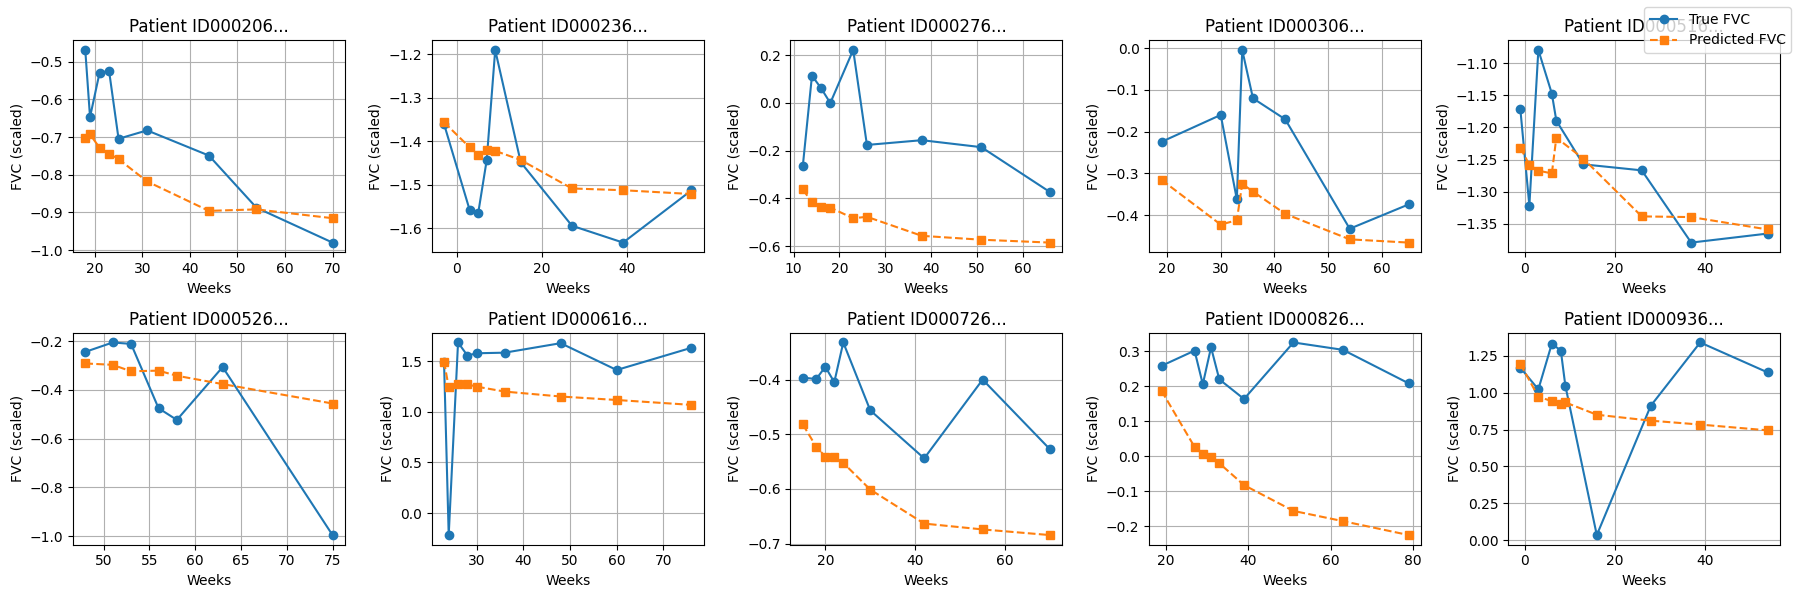

In [ ]:
plot_grut_grid(
    model=model,
    dataset=val_dataset,
    weeks_seqs= weeks_val_seqs,
    patient_ids=val_patients,
    n_rows=2,
    n_cols=5,
    ci_dict=None,
    figsize=(18, 6)
)